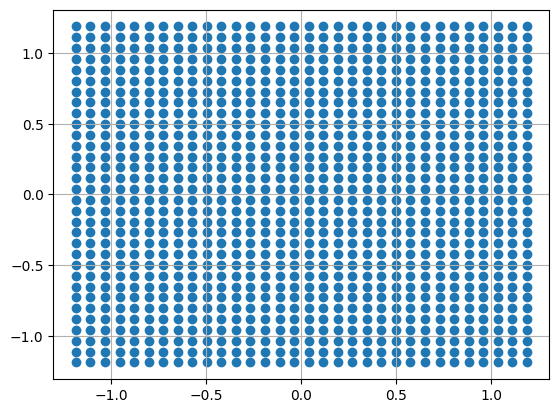

Average energy of the constellation:  0.9999999999999998


In [11]:
import numpy as np

# Get a QAM constellation of size M
def get_qam_constellation(set_size=4):
    """
    Get a QAM constellation of size M.

    :param set_size: Size of the QAM constellation
    :return: QAM constellation of the specified size
    """
    set_size_real = int(np.sqrt(set_size))
    set_size_imag = set_size_real

    x_real_vec = np.linspace(-2*set_size_real+1, 2*set_size_real-1, set_size_real)
    x_imag_vec = x_real_vec
    x_real, x_imag = np.meshgrid(x_real_vec, x_imag_vec)

    x = x_real + 1j * x_imag  # Complex set of symbols

    # Normalize the energy to 1
    x = x / np.sqrt(np.mean(np.abs(x)**2))

    # Stack to get real and imaginary parts of the symbols (set_size, 2)
    x_vec = np.stack((np.real(x).ravel(), np.imag(x).ravel()), axis=-1)
    return x_vec
    

set_x_size = 1024
x = get_qam_constellation(set_size=set_x_size)

import matplotlib.pyplot as plt
plt.scatter(x[:, 0], x[:, 1])
plt.grid()
plt.show()

# Compute average energy of the constellation
avg_energy = np.mean(np.abs(x[:, 0])**2 + np.abs(x[:, 1])**2)
print("Average energy of the constellation: ", avg_energy)

100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


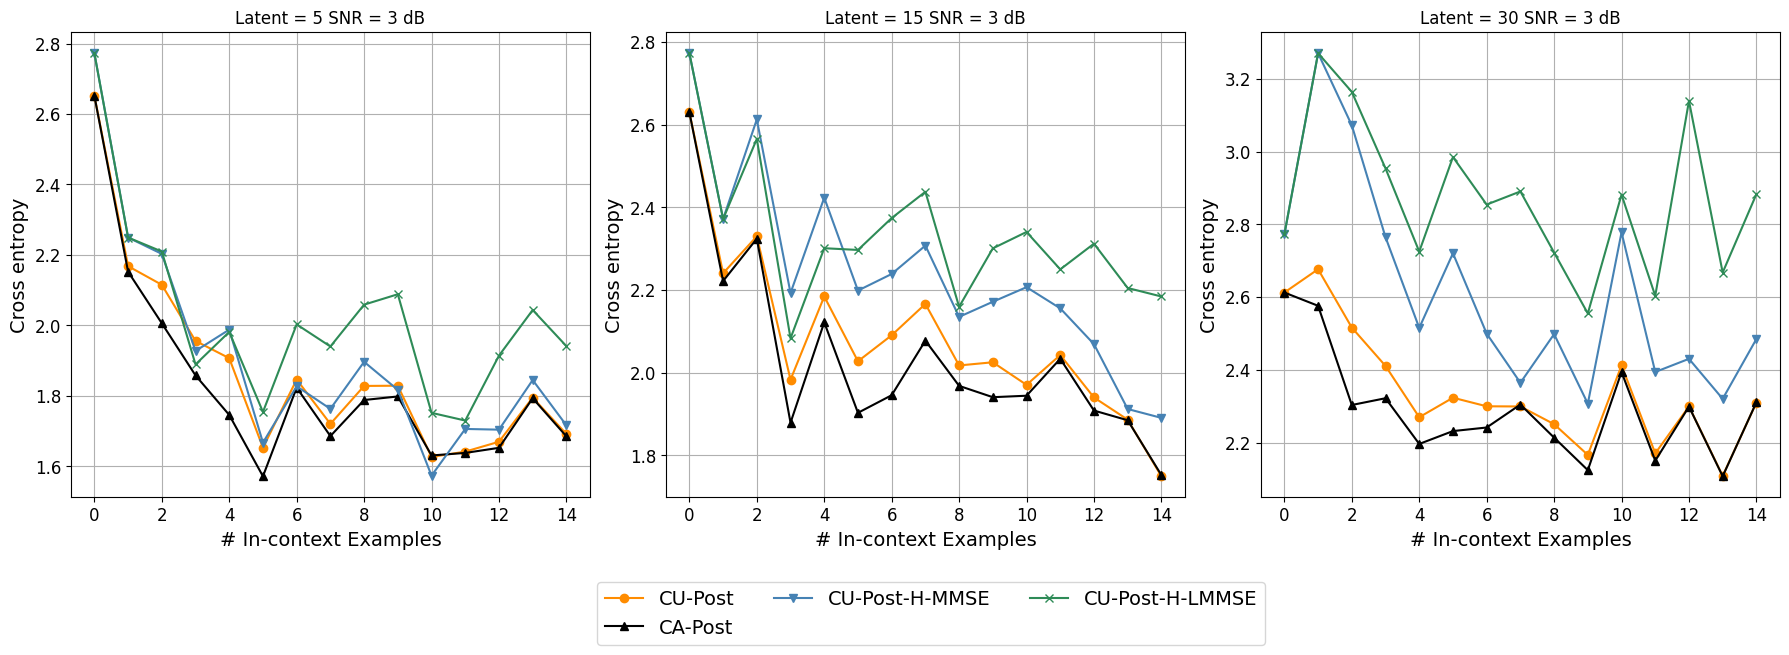

In [12]:
# from operator import length_hint
import numpy as np
from numpy.linalg import norm
import seaborn as sns
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


def get_cov_h(latent=5, max_context_len=15, carrier_freq=2.6e9, symb_time=1e-3):

    """
    Given a latent value, generate the covariance matrix of the channel process.

    :param latent: Latent value representing the context which is the relative velocity between the transmitter and receiver
    :param max_context_len: Maximum context length
    :param carrier_freq: Carrier frequency
    :param symb_time: Symbol time
    :return: Covariance matrix of the channel process, Eigenvalues of the covariance matrix, Eigenvectors of the covariance matrix
    """

    c = sp.constants.c
    velocity = latent
    max_doppler_shift = carrier_freq * velocity / c

    corr_h_col = 2 * np.pi * max_doppler_shift * symb_time * np.arange(max_context_len)
    corr_h_row = corr_h_col
    corr_h = sp.special.j0(toeplitz(corr_h_col, corr_h_row))
    lam_h, u_comp = np.linalg.eig(corr_h) # Very close to real matrices
    u = np.real(u_comp) # To be safe from num errs
    lam = np.abs(lam_h) # To be safe from num errs
    return corr_h, lam, u.T  # Returning u.T


def sample_h(lam, u_t, batch_size, d, sigma_h2):
    """
    Given the eigenvalues and eigenvectors of the covariance matrix of the channel process, sample the channel matrix.
    
    :param lam: Eigenvalues of the covariance matrix
    :param u_t: Eigenvectors of the covariance matrix
    :param batch_size: Number of examples in the batch
    :param d: Number of antennas
    :param sigma_h2: Channel power
    :return: Channel matrix of shape (batch_size, context_len, d)
    """

    sigma_h = np.sqrt(sigma_h2)
    context_len = len(lam)
    g_real, g_imag = sigma_h * np.random.randn(batch_size, d, context_len), sigma_h * np.random.randn(batch_size, d, context_len)
    g = g_real + 1j* g_imag
    h = g @ np.diag(lam**0.5) @ u_t # (batch_size, d, context_len)
    return h.transpose((0, 2, 1)) # (batch_size, context_len, d)


def gen_time_variant_process(set_x,
                            latent=5,
                            max_context_len=10,
                            batch_size=100,
                            d=4,
                            snr_db=-5,
                            sigma_h2=1/2):
    """
    Given a set_x, generate a time-variant process corresponding to the given latent value.

    :param set_x: Set of possible input symbols
    :param latent: Latent value representing the context which is the relative velocity between the transmitter and receiver
    :param max_context_len: Maximum context length
    :param batch_size: Number of examples in the batch
    :param d: Number of antennas
    :param snr_db: SNR in dB
    :param sigma_h2: Channel power
    :return: x, y, h, s where x is the input symbols, y is the output symbols, h is the channel, and s is the true symbol
    """
    
    sigma2 = 10**(-snr_db/10)
    sigma = np.sqrt(sigma2)

    # Sample z
    z_real, z_imag = sigma*np.random.randn(batch_size, max_context_len, d), sigma*np.random.randn(batch_size, max_context_len, d)  # generate noise samples
    z = z_real + 1j*z_imag    

    # Sample x
    s = np.random.choice(len(set_x), size=(batch_size, max_context_len), replace=True)
    x_vec = set_x[s]  # generate input symbs
    x_real, x_imag = x_vec[:,:,0], x_vec[:,:,1]
    x = (x_real + 1j * x_imag).reshape(batch_size, max_context_len, 1)

    # Sample h
    corr_h, lam_h, u_t = get_cov_h(latent=latent, max_context_len=max_context_len, carrier_freq=2.6e9, symb_time=1e-3)
    h = sample_h(lam_h, u_t, batch_size, d, sigma_h2) # (batch_size, max_context_len, d)

    y = h*x + z
    return x, y, h, s   
    

def complex_to_real_mat(complex_3d):
    """
    Given a complex valued 3D tensor, convert it to a real valued 3D tensor as described in the paper.

    :param complex_3d: A complex valued tensor of shape (batch_size, context_len, d)
    :return: A real valued tensor of shape (batch_size, context_len, 2d)
    """
    batch_size, n_symbols, _ = complex_3d.shape
    vec_real = np.expand_dims(np.real(complex_3d), axis=2) # batch_size, context_len, 1, d
    vec_imag = np.expand_dims(np.imag(complex_3d), axis=2) # batch_size, context_len, 1, d
    return np.concatenate((vec_real, vec_imag), axis=2).reshape(batch_size, n_symbols, -1) # batch_size, context_len, 2d


def get_in_mat(x, d):
    """
    Convert the input symbols to the input matrix as given in the paper.

    :param x: Complex-valued input symbols of shape (batch_size, context_len, 1)
    :param d: Number of antennas
    :return: Input matrix of shape (batch_size, 2*d*context_len, 2*d*context_len)
    """
   
    x_real = np.real(x)  # (batch_size, context_len, 1)
    x_imag = np.imag(x)  # (batch_size, context_len, 1)

    mat1 = np.expand_dims(np.concatenate((x_real, -x_imag), axis=-1), axis=-2)  # (batchsize, cnxt_ln, 1, 2)
    mat2 = np.expand_dims(np.concatenate((x_imag, x_real), axis=-1), axis=-2) # (batchsize, cnxt_ln, 1, 2)

    mat_stacked = np.concatenate((mat1, mat2), axis=-2) # (batchsize, cnxt_ln, 2, 2)

    batch_size, context_len, _, _ = mat_stacked.shape
    
    # Initialize an empty matrix of the required shape filled with zeros
    mat = np.zeros((batch_size, context_len * 2, context_len * 2))
    
    # Fill the diagonal blocks with the input matrices
    for i in range(context_len):
        mat[:, i * 2: (i + 1) * 2, i * 2: (i + 1) * 2] = mat_stacked[:, i]
    
    x_mat = np.kron(mat, np.eye(d))
    return x_mat



def get_likelihoods(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=-5, 
                    latent=5,
                    d=4):
    """
    Compute the likelihood of the received symbols given past input and output symbols.

    :param y_curr: Complex-valued current out symbols of shape (batch_size, d)
    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param set_x: Set of possible input symbols
    :param snr_db: SNR in dB
    :param latent: Latent value representing the context which is the relative velocity between the transmitter and receiver
    :param d: Number of antennas
    :return: Likelihood of the received symbols given the past input and output symbols (batch_size, card_set_x)
    """

    sigma2 = 10**(-snr_db/10)
    likelihood_mass = np.zeros((len(y_curr), len(set_x)))
    batch_size = len(y_curr)
    
    sigma2 = 10**(-snr_db/10)
    sigma_h2 = 1/2

    y_curr = np.expand_dims(y_curr, axis=1)
    any_past = x_past.any()
    if any_past:
        y_full = np.concatenate((y_past, y_curr), axis=1)
    else:
        y_full = y_curr

    
    max_context_len = len(y_full[0])

    # convert to real-valued

    y_mat = complex_to_real_mat(y_full)
    y_vec = y_mat.reshape(len(y_mat), -1, 1)  # yk (batchsize, 2kd, 1)
    y_vec_t = y_vec.swapaxes(-1, -2)  # Transpose of y_vec

    y_vec_dim = len(y_vec[0])
    corr_h, _, _ = get_cov_h(latent=latent, max_context_len=max_context_len, carrier_freq=2.6e9, symb_time=1e-3)

    for idx, x_real_vec in enumerate(set_x):
        x = x_real_vec[0] + 1j* x_real_vec[1]
        x_curr = np.tile(x, (batch_size, 1, 1))
        if any_past:
            x_full = np.concatenate((x_past, x_curr), axis=1)
        else:
            x_full = x_curr

        x_mat = get_in_mat(x_full, d)  # (batchsize, 2kd, 2kd)  Xk
        x_mat_t = np.swapaxes(x_mat, axis1=-1, axis2=-2) # (batchsize, 2kd, 2kd) Xk.T
        eye_mat = np.eye(y_vec_dim).reshape(1,y_vec_dim,-1)

        corr_y = sigma_h2 * x_mat @ (np.kron(corr_h, np.eye(2*d))) @ x_mat_t + sigma2 * eye_mat
        corr_y_inv = np.linalg.inv(corr_y)

        likelihood_mass[:, idx] =  1 / np.sqrt(np.abs(np.linalg.det(corr_y))) * np.exp(-1/2* (y_vec_t @ corr_y_inv @ y_vec).squeeze())
    
    return likelihood_mass


def compute_mmse(y_past,
                x_past, 
                snr_db=-5,
                d=4,
                latents=(5, 15, 30),
                sigma_h2=1/2):
    
    """
    Compute the MMSE estimate of the channel from the received symbols and the pilots.

    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param snr_db: SNR in dB
    :param d: Number of antennas
    :param latents: Latent values representing the context which is the relative velocity between the transmitter and receiver
    :param sigma_h2: Channel power
    :return: MMSE estimate of the channel (batch_size, 2d)
    """
    

    sigma2 = 10**(-snr_db/10)
    batch_size = len(y_past)
    max_context_len = len(y_past[0])

    # Convert to real-valued
    y_mat = complex_to_real_mat(y_past)
    y_vec = y_mat.reshape(len(y_mat), -1, 1)  # yk (batch_size, 2kd, 1)
    y_vec_t = y_vec.swapaxes(-1, -2)

    y_vec_dim = len(y_vec[0])

    filter = np.zeros((batch_size, 2 * d, 2 * d * max_context_len, len(latents)))  # Filter for the latent
    posterior = np.zeros((batch_size, len(latents)))  # Posterior for the latent
    
    for i, latent in enumerate(latents):
        
        corr_h, _, _ = get_cov_h(latent=latent, max_context_len=max_context_len+1, carrier_freq=2.6e9, symb_time=1e-3)
        corr_past = corr_h[:-1, :-1] * sigma_h2  # Scale with channel power  (k, k)
        corr_curr_past = corr_h[-1, :-1] * sigma_h2  # Correlation between current and past hidden states (k,)

        x_mat = get_in_mat(x_past, d)  # (batchsize, 2kd, 2kd)  Xk
        x_mat_t = np.swapaxes(x_mat, axis1=-1, axis2=-2) # (batchsize, 2kd, 2kd) Xk.T
        eye_mat = np.eye(y_vec_dim).reshape(1,y_vec_dim,-1)

        corr_y = x_mat @ (np.kron(corr_past, np.eye(2*d))) @ x_mat_t + sigma2*eye_mat
        corr_y_inv = np.linalg.inv(corr_y)
        corr_hy = np.kron(corr_curr_past, np.eye(2*d)) @ x_mat_t  # (batch_size, 2d, 2dk)

        filter[:,:,:,i] = corr_hy @ corr_y_inv  # Filter for the latent
        posterior[:,i] = 1 / np.sqrt(np.abs(np.linalg.det(corr_y))) * np.exp(-1/2* (y_vec_t @ corr_y_inv @ y_vec).squeeze())  # Posterior for the latent


    posterior_expd = np.expand_dims(posterior, axis=(1, 2))
    cu_filter = np.sum(filter * posterior_expd, axis=-1) /  np.sum(posterior_expd, axis=-1)  # Weigh the filters with the posterior to get a context-unware filter
    h_mmse = cu_filter @ y_vec  # This gives the MMSE estimate of the channel (batch_size, 2d, 1)

    return h_mmse.squeeze()  # (batch_size, 2d)




def compute_lmmse(y_past,
                x_past, 
                snr_db=-5,
                d=4,
                latents=(5, 15, 30),
                sigma_h2=1/2):
    """
    Compute the LMMSE estimate of the channel from the received symbols and the pilots.

    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param snr_db: SNR in dB
    :param d: Number of antennas
    :param latents: Latent values representing the context which is the relative velocity between the transmitter and receiver
    :param sigma_h2: Channel power
    :return: LMMSE estimate of the channel (batch_size, 2d)
    """
    
    sigma2 = 10**(- snr_db / 10)

    max_context_len = len(y_past[0])

    # Convert to real-valued
    y_mat = complex_to_real_mat(y_past)
    y_vec = y_mat.reshape(len(y_mat), -1, 1)  # yk (batch_size, 2kd, 1)
    y_vec_dim = len(y_vec[0])

    corr_h_all = np.zeros((len(latents), max_context_len+1, max_context_len+1))  # Get the covariance matrices for all the latents

    for i, latent in enumerate(latents):
        corr_h_all[i,:,:], _, _  = get_cov_h(latent=latent, max_context_len=max_context_len+1, carrier_freq=2.6e9, symb_time=1e-3)

    corr_h_avg = np.mean(corr_h_all, axis=0)
    corr_h_past = corr_h_avg[:-1, :-1] * sigma_h2  # scale with channel power  (k,k)
    corr_h_curr_past = corr_h_avg[-1, :-1] * sigma_h2  # (k,)

    x_mat = get_in_mat(x_past, d)  # (batch_size, 2kd, 2kd)  Xk
    x_mat_t = np.swapaxes(x_mat, axis1=-1, axis2=-2) # (batch_size, 2kd, 2kd) Xk.T
    eye_mat = np.eye(y_vec_dim).reshape(1,y_vec_dim,-1)

    corr_y = x_mat @ (np.kron(corr_h_past, np.eye(2*d))) @ x_mat_t + sigma2*eye_mat
    corr_y_inv = np.linalg.inv(corr_y)

    corr_hy = np.kron(corr_h_curr_past, np.eye(2*d)) @ x_mat_t  # (batch_size, 2d, 2dk)
    lmmse_filter = corr_hy @ corr_y_inv
    h_lmmse = lmmse_filter @ y_vec  # (batch_size, 2d, 1)

    return h_lmmse.squeeze()  # (batch_size, 2d)


def compute_context_unware_posterior_from_lmmse(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=-5,
                    d=4,
                    latents=(5, 15, 30)):
    
    """
    Compute the context unware posterior of x_curr from y_curr, and by using the LMMSE estimate of the channel computed from (y_past, x_past).
    This is the standard approach used in wireless systems, which perform equalization using the LMMSE estimate of the channel.

    :param y_curr: Complex-valued current out symbols of shape (batch_size, d)
    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param set_x: Set of possible input symbols
    :param snr_db: SNR in dB
    :param d: Number of antennas
    :param latents: Latent values representing the context which is the relative velocity between the transmitter and receiver
    :return: Context unware posterior of x_curr given y_curr (batch_size, card_set_x)
    """
    sigma2 = 10**(-snr_db/10)
    batch_size = len(y_curr)

    any_past = y_past.any()

    if not any_past:  # If no pilots, best estimate of channel is all-zeros which is the mean of the channel process
        h_est_vec = np.zeros((batch_size, 2*d))
    else:
        h_est_vec = compute_lmmse(y_past,
                                x_past,
                                snr_db=snr_db,
                                d=d,
                                latents=latents,
                                sigma_h2=1/2)
    
    h_est_real, h_est_imag = h_est_vec[:, :d], h_est_vec[:, d:]
    h_est = h_est_real + 1j* h_est_imag  # (batch_size, d)
    post_x_curr = np.zeros((batch_size, len(set_x)))

    for i, x_real in enumerate(set_x):
        x = x_real[0] + 1j* x_real[1]
        post_x_curr[:,i] = np.exp(- 1 / 2 / sigma2 * np.sum(np.abs(y_curr-h_est*x)**2, axis=-1))

    post_x_curr = post_x_curr / np.expand_dims(np.sum(post_x_curr, axis=-1), axis=-1)
    map_x_curr = np.argmax(post_x_curr, axis=-1)
    return post_x_curr



def compute_context_unware_posterior_from_mmse(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=-5,
                    d=4,
                    latents=(5,15,30)):
    
    """
    Compute the context unware posterior of x_curr from y_curr, and by using the MMSE estimate of the channel computed from (y_past, x_past).
    This is computationally intensive as we need to compute filters for all the latents and then weigh them with the posterior. 
    Each filter computation involves the inversion of a matrix of size 2kd x 2kd, which is expensive.

    :param y_curr: Complex-valued current out symbols of shape (batch_size, d)
    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param set_x: Set of possible input symbols
    :param snr_db: SNR in dB
    :param d: Number of antennas
    :param latents: Latent values representing the context which is the relative velocity between the transmitter and receiver
    :return: Context unware posterior of x_curr given y_curr (batch_size, card_set_x), from the MMSE estimate of the channel
    """

    sigma2 = 10**(-snr_db/10)
    batch_size = len(y_curr)

    any_past = y_past.any()

    if not any_past:  # if not pilots, best estimate of channel is all-zeros
        h_est_vec = np.zeros((batch_size, 2*d))
    else:
        h_est_vec = compute_mmse(
                                y_past,
                                x_past,
                                snr_db=snr_db,
                                d=d,
                                latents=latents,
                                sigma_h2=1/2
                            )
    
    h_est_real, h_est_imag = h_est_vec[:,:d], h_est_vec[:,d:]
    h_est = h_est_real + 1j * h_est_imag  # (batch_size, d)

    post_x_curr = np.zeros((batch_size, len(set_x)))
    for idx, x_real_vec in enumerate(set_x):
        x = x_real_vec[0] + 1j* x_real_vec[1]
        post_x_curr[:,idx] = np.exp(- 1 / 2 / sigma2 * np.sum(np.abs(y_curr - h_est * x)**2, axis=-1))

    post_x_curr = post_x_curr / np.expand_dims(np.sum(post_x_curr, axis=-1), axis=-1)
    map_x_curr = np.argmax(post_x_curr, axis=-1)
    return post_x_curr



def compute_posterior(y_curr, 
                    y_past, 
                    x_past, 
                    set_x,
                    true_latent=5, 
                    snr_db=-5,
                    d=4,
                    latents=(5,15,30)):
    """
    Compute the context-unware, and context-aware posterior of x_curr given y_curr, y_past, x_past, and set_x.
    
    :param y_curr: Complex-valued current out symbols of shape (batch_size, d)
    :param y_past: Complex-valued past out symbols of shape (batch_size, k, d)
    :param x_past: Complex-valued past in symbols of shape (batch_size, k, 1)
    :param set_x: Set of possible input symbols
    :param true_latent: True latent value
    :param snr_db: SNR in dB
    :param d: Number of antennas
    :param latents: Latent values representing the context which is the relative velocity between the transmitter and receiver
    :return: Context-unaware posterior (batch_size, card_set_x), Context-aware posterior (batch_size, card_set_x)
    """
    
    batch_size, card_set_x, n_latents = len(y_curr), len(set_x), len(latents)
    l_x_curr = np.zeros((batch_size, card_set_x, n_latents))  # Likelihoods for x_curr
    for i, latent in enumerate(latents):
        l_x_curr[:, :, i] = get_likelihoods(y_curr, 
                    y_past, 
                    x_past, 
                    set_x, 
                    snr_db=snr_db, 
                    latent=latent,
                    d=d)

        if latent == true_latent:
            true_l_x_curr = l_x_curr[:, :, i].copy()  # Likelihood corresponding to the true latent
    
    cu_post = np.average(l_x_curr, axis=-1)

    cu_post_x_curr = cu_post / np.expand_dims(np.sum(cu_post, axis=-1), axis=1)  # Context-unaware posterior
    ca_post_x_curr = true_l_x_curr / np.expand_dims(np.sum(true_l_x_curr, axis=-1), axis=1)  # Context-aware posterior

    cu_map_x_curr = np.argmax(cu_post_x_curr, axis=-1)
    ca_map_curr = np.argmax(ca_post_x_curr, axis=-1)

    return cu_post_x_curr, ca_post_x_curr


# Get a QAM constellation of size M
def get_qam_constellation(set_size=4):
    """
    Get a QAM constellation of size M.

    :param set_size: Size of the QAM constellation
    :return: QAM constellation of the specified size
    """
    set_size_real = int(np.sqrt(set_size))
    set_size_imag = set_size_real

    x_real_vec = np.linspace(-2*set_size_real+1, 2*set_size_real-1, set_size_real)
    x_imag_vec = x_real_vec
    x_real, x_imag = np.meshgrid(x_real_vec, x_imag_vec)

    x = x_real + 1j * x_imag  # Complex set of symbols

    # Normalize the energy to 1
    x = x / np.sqrt(np.mean(np.abs(x)**2))

    # Stack to get real and imaginary parts of the symbols (set_size, 2)
    x_vec = np.stack((np.real(x).ravel(), np.imag(x).ravel()), axis=-1)
    return x_vec


# Get QPSK constellation
def get_qpsk_constellation():
    """
    Get a QPSK constellation of size M.

    :param set_size: Size of the QPSK constellation
    :return: QPSK constellation of the specified size
    """
    x_vec = np.array([[1, 1],[1, -1],[-1, 1],[-1, -1]])
    return x_vec
    


# Plotting

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color='darkred',
        marker='s',
        linewidth=2,
        markersize=4,
        legend=False
    )


signal_type = 'qam'

if signal_type == 'qpsk':
    set_x = get_qpsk_constellation()
elif signal_type == 'qam':
    set_x_size = 16
    set_x = get_qam_constellation(set_size=set_x_size)
else:
    raise ValueError("Invalid signal type")

batch_size = 100
max_context_len = 14
d = 4
snr_db  = 3  # For 16-QAM, 3 dB is a good value
latents = (5, 15, 30)

# ce_tf_v5 = np.load('../results/v1_5_CE_tf_detection_time_variant_snr_0.npy')
# ce_tf_v15 = np.load('../results/v2_15_CE_tf_detection_time_variant_snr_0.npy')
# ce_tf_v30 = np.load('../results/v3_30_CE_tf_detection_time_variant_snr_0.npy')
# ce_tf = [ce_tf_v5, ce_tf_v15, ce_tf_v30]

n_axs = len(latents)

fig, axs = plt.subplots(1, n_axs, figsize=(6*n_axs, 6), sharex=True)

for i, true_latent in enumerate(latents):

    x, y, h, s = gen_time_variant_process(set_x,
                                        latent=true_latent,
                                        max_context_len=max_context_len+1,
                                        batch_size=batch_size,
                                        d=d,
                                        snr_db=snr_db,
                                        sigma_h2=1/2)

    ce_cu_post = np.zeros(len(x[0]))
    ce_ca_post = np.zeros(len(x[0]))
    ce_cu_post_mmse = np.zeros(len(x[0]))
    ce_cu_post_lmmse = np.zeros(len(x[0]))
    for k in tqdm(range(max_context_len+1)):
        y_curr = y[:,k,:]
        x_curr = x[:,k,0]
        s_curr = s[:, k]
        y_past = y[:,:k,:]
        x_past = x[:,:k,:]


        cu_post_mmse = compute_context_unware_posterior_from_mmse(y_curr, 
                                    y_past, 
                                    x_past, 
                                    set_x,
                                    snr_db=snr_db,
                                    d=d)

        cu_post, ca_post = compute_posterior(y_curr, 
                        y_past, 
                        x_past, 
                        set_x,
                        true_latent=true_latent, 
                        snr_db=snr_db,
                        d=d)
        
        cu_post_lmmse = compute_context_unware_posterior_from_lmmse(y_curr, 
                                    y_past, 
                                    x_past, 
                                    set_x,
                                    snr_db=snr_db,
                                    d=d)
    

        # Compute the cross-entropy of the posterior estimates by different methods with the true symbols
        ce_cu_post_mmse[k] = -np.mean(np.log(cu_post_mmse[np.arange(batch_size), s_curr]))
        ce_cu_post[k] = -np.mean(np.log(cu_post[np.arange(batch_size), s_curr]))
        ce_ca_post[k] = -np.mean(np.log(ca_post[np.arange(batch_size), s_curr]))
        ce_cu_post_lmmse[k] = -np.mean(np.log(cu_post_lmmse[np.arange(batch_size), s_curr]))

    np.save(f'../results/ce_cu_post_v{true_latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post)
    np.save(f'../results/ce_ca_post_v{true_latent}_{signal_type}_snr_db{snr_db}.npy', ce_ca_post)
    np.save(f'../results/ce_cu_post_mmse_v{true_latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post_mmse)
    np.save(f'../results/ce_cu_post_lmmse_v{true_latent}_{signal_type}_snr_db{snr_db}.npy', ce_cu_post_lmmse)

    axs[i].plot(ce_cu_post, label='CU-Post', color='darkorange', marker='o')
    axs[i].plot(ce_ca_post, label='CA-Post', color='k', marker='^')
    axs[i].plot(ce_cu_post_mmse, label='CU-Post-H-MMSE', color='steelblue', marker='v')
    axs[i].plot(ce_cu_post_lmmse, label='CU-Post-H-LMMSE', color='seagreen', marker='x')

    # lineplot_with_ci(ce_tf[i][:, :max_context_len+1],
    #     n_points=max_context_len+1,
    #     offset=0,
    #     label="Transformer",
    #     ax=axs[i])
    # axs[i].plot(np.mean(ce_tf[i], axis=0), label='Transformer', color='darkred', marker='s')

    axs[i].set_title(f'Latent = {true_latent} SNR = {snr_db} dB')
    axs[i].grid()


for ax in axs:
    ax.set_xlabel("# In-context Examples", fontsize=14)
    ax.set_ylabel("Cross entropy", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Shared legend from the last plot
lines, labels = axs[len(latents)-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f'../plots/ce_time_var_{signal_type}_snr_db{snr_db}.png', format='png', bbox_inches='tight', dpi=400)
    


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl

# Plotting

def get_df_from_pred_array(pred_arr, n_points, offset=0):
    # pred_arr --> b x pts-1
    batch_size = pred_arr.shape[0]
    flattened_arr = pred_arr.ravel()
    points = np.array(list(range(offset, n_points)) * batch_size)
    df = pd.DataFrame({"y": flattened_arr, "x": points})
    return df


def lineplot_with_ci(pred_or_err_arr, n_points, offset, label, ax, color='darkred', lw=2):
    sns.lineplot(
        data=get_df_from_pred_array(pred_or_err_arr, n_points=n_points, offset=offset),
        y="y",
        x="x",
        label=label,
        ax=ax,
        n_boot=1000,
        errorbar=('ci', 90),
        color=color,
        linewidth=lw,
        markersize=4,
        legend=False,
        marker='s'
    )


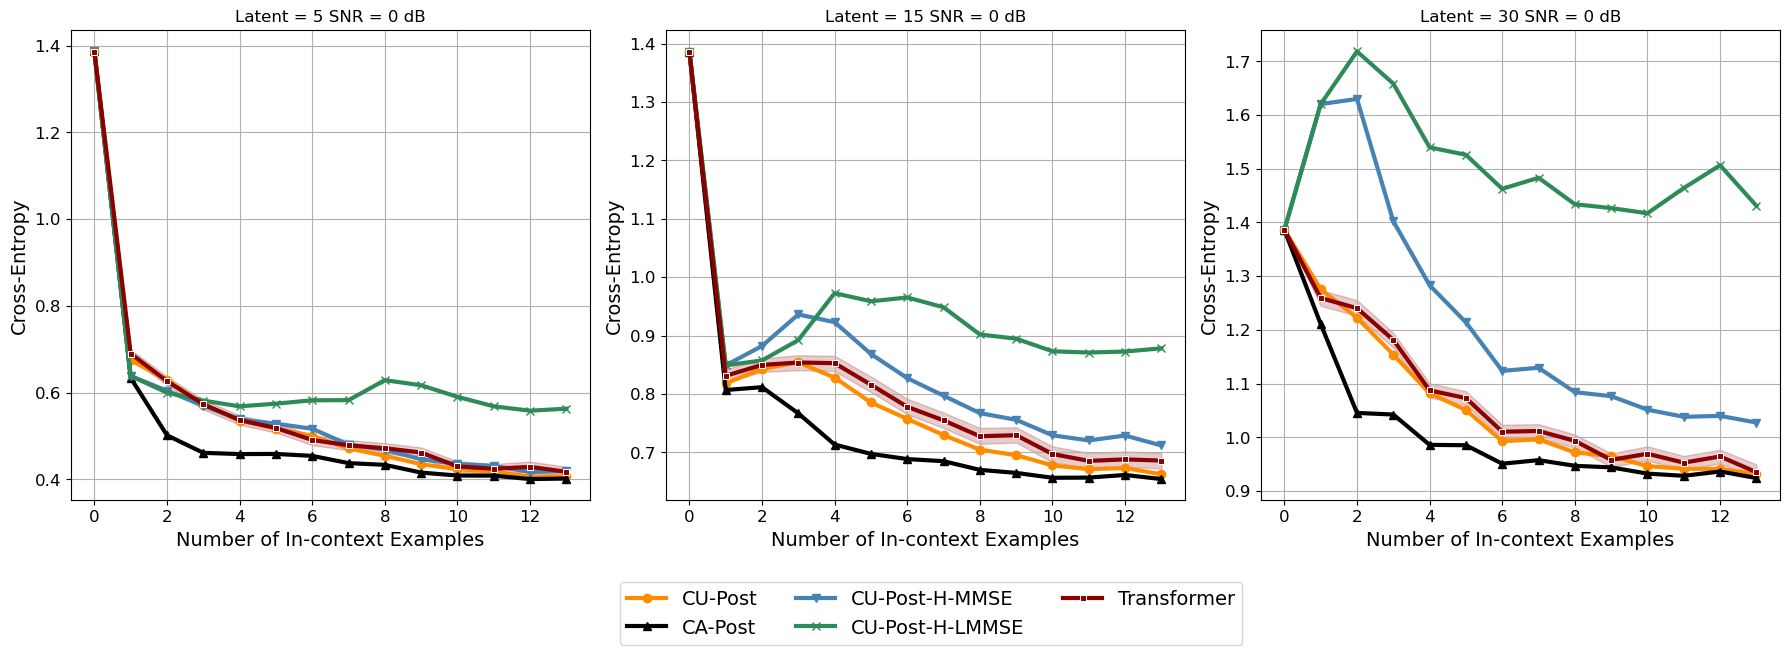

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

darkblue =  '#2F3E51'
darkred = '#500000'

lightblue = '#AEB7CF'
customgray = '#707070'

tan = "#D6D3C4"


colors = [darkblue, lightblue, tan,  'k',  darkred]

colors = ['seagreen', 'darkorange', 'steelblue', 'k', 'darkred']
colors = ['darkorange', 'k', 'steelblue', 'seagreen', 'darkred']

lws = [3, 3, 3]

latents = (5, 15, 30)

n_axs = len(latents)
snr_db = 0

fig, axs = plt.subplots(1, n_axs, figsize=(6*n_axs, 6), sharex=True)


ce_tf_v5 = np.load('../Files/v1_5_CE_tf_detection_time_variant_snr_0.npy')
ce_tf_v15 = np.load('../Files/v2_15_CE_tf_detection_time_variant_snr_0.npy')
ce_tf_v30 = np.load('../Files/v3_30_CE_tf_detection_time_variant_snr_0.npy')

max_context_len = 14

ce_tf = [ce_tf_v5, ce_tf_v15, ce_tf_v30]

n = 0

x_pts = np.arange(n, max_context_len+n)



for idx, true_latent in enumerate(latents):

    ce_cu_post = np.load(f'../Files/CE_CU_x_MSE_QPSK_lat_{true_latent}.npy')
    ce_ca_post = np.load(f'../Files/CE_CA_x_MSE_QPSK_lat_{true_latent}.npy')
    ce_cu_post_mmse = np.load(f'../Files/CE_CU_xh_MSE_QPSK_lat_{true_latent}.npy')
    ce_cu_post_lmmse = np.load(f'../Files/CE_CU_xh_Lin_MSE_QPSK_lat_{true_latent}.npy')

    axs[idx].plot(x_pts, ce_cu_post[n:max_context_len+n], label='CU-Post', color=colors[0], marker='o', lw=lws[0])
    axs[idx].plot(x_pts, ce_ca_post[n:max_context_len+n], label='CA-Post', color=colors[1], marker='^', lw=lws[0])
    axs[idx].plot(x_pts, ce_cu_post_mmse[n:max_context_len+n], label='CU-Post-H-MMSE', color=colors[2], marker='v', lw=lws[0])
    axs[idx].plot(x_pts, ce_cu_post_lmmse[n:max_context_len+n], label='CU-Post-H-LMMSE', color=colors[3], marker='x', lw=lws[0])

    lineplot_with_ci(ce_tf[idx][:, n:max_context_len+n],
        n_points=max_context_len+n,
        offset=n,
        label="Transformer",
        ax=axs[idx], color=colors[4], lw=lws[2])
    # axs[i].plot(np.mean(tf_SEP[i], axis=0), label='Transformer', color='darkred', marker='s')
    axs[idx].set_title(f'Latent = {true_latent} SNR = {snr_db} dB')
    axs[idx].grid()


for ax in axs:
    ax.set_xlabel("Number of In-context Examples", fontsize=14)
    ax.set_ylabel("Cross-Entropy", fontsize=14)
    # ax.set_ylim([-5,105])
    # ax.set_xticks(np.arange(3,15,3))
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_xlim([0.9, max_cnxt_ln])
    ax.set_xticks(np.arange(n,max_context_len, 2))

# Shared legend from the last plot
lines, labels = axs[len(latents)-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center',bbox_to_anchor=(0.52,-0.15), ncol=3, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Plots/CE-time-variant-SNR0-baselines-QPSK.png', format='png', bbox_inches='tight', dpi=400)

In [8]:
import numpy as np

b = 1000
n = 10
sigma2 = 0.01

x = 2*np.random.randint(2, size=(b,n))-1

z = np.sqrt(sigma2) * np.random.randn(*x.shape)

print(z)









[[-0.03342844  0.06980087 -0.04821182 ... -0.10243186 -0.10880368
   0.13183996]
 [-0.0004122  -0.03159904  0.02529714 ... -0.11856635  0.11282434
  -0.11101553]
 [ 0.131881   -0.07436363 -0.02026379 ...  0.01429504 -0.02257818
   0.09553133]
 ...
 [-0.17990506  0.0211638  -0.06588507 ...  0.03420093 -0.06593629
   0.00767858]
 [-0.04582961 -0.09225037 -0.01023626 ...  0.07776468  0.09662291
   0.10608188]
 [ 0.28949608  0.07171927 -0.21160101 ... -0.15999232  0.13092394
  -0.02188483]]
